In [1]:
# for google colab
from google.colab import drive
# mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/Shareddrives/'AI Final Project'/code

/content/gdrive/Shareddrives/AI Final Project/code


In [3]:
data_path = '/content/gdrive/Shareddrives/AI Final Project/dataset'

In [ ]:
# for google colab
# copy all files from "AI_HW1" directory in Google drive to current directory
# 直接cd過來應該就不用cp了(not sure)
# !cp -r ./gdrive/Shareddrives/'AI Final Project'/code/* .

In [4]:
#For Images
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For checking progress
from tqdm import tqdm_notebook

# This is for the progress bar.
from tqdm.auto import tqdm

import datetime

#PyTorch Packages
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import time

## **Dataset, Data Loader, and Transforms**

In [5]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [6]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder(data_path + "/train", loader=lambda x: Image.open(x).convert("RGB"), extensions="png", transform=train_tfm)
test_set = DatasetFolder(data_path + "/test", loader=lambda x: Image.open(x).convert("RGB"), extensions="png", transform=test_tfm)

# split train set into train and valid set
# valid_set = DatasetFolder(data_path + "/train", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# 法1
# validation_split = .2
# shuffle_dataset = True
# random_seed= 42

# # Creating data indices for training and validation splits:
# dataset_size = len(train_set)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# 法2
train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

# Construct data loaders.
# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, pin_memory=True, sampler=train_sampler)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=2, pin_memory=True, sampler=valid_sampler)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# src: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **Model**


In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 64, 64]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),#output 64*64*64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#output 64*32*32

            nn.Conv2d(64, 128, 3, 1, 1),#output 128*32*32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),#output 128*16*16

            nn.Conv2d(128, 256, 3, 1, 1),#output 256*16*16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),#output 256*4*4
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

t1 = time.time()

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 50

training_loss_epochs = []
validation_loss_epochs = []
training_accuracy_epochs = []
validation_accuracy_epochs = []

for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    
    training_loss_epochs.append(train_loss)
    training_accuracy_epochs.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    validation_loss_epochs.append(valid_loss)
    validation_accuracy_epochs.append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

t2 = time.time()
print('time elapsed: ' + str(t2-t1) + ' seconds')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



[ Train | 001/050 ] loss = 0.62132, acc = 0.78680



[ Valid | 001/050 ] loss = 0.31623, acc = 0.89149



[ Train | 002/050 ] loss = 0.21998, acc = 0.92301



[ Valid | 002/050 ] loss = 0.19188, acc = 0.93142



[ Train | 003/050 ] loss = 0.15130, acc = 0.94350



[ Valid | 003/050 ] loss = 0.19036, acc = 0.92405



[ Train | 004/050 ] loss = 0.11075, acc = 0.96196



[ Valid | 004/050 ] loss = 0.15420, acc = 0.94444



[ Train | 005/050 ] loss = 0.09232, acc = 0.96773



[ Valid | 005/050 ] loss = 0.09942, acc = 0.96094



[ Train | 006/050 ] loss = 0.07158, acc = 0.97498



[ Valid | 006/050 ] loss = 0.12173, acc = 0.95269



[ Train | 007/050 ] loss = 0.06807, acc = 0.97509



[ Valid | 007/050 ] loss = 0.06886, acc = 0.97613



[ Train | 008/050 ] loss = 0.03245, acc = 0.98970



[ Valid | 008/050 ] loss = 0.05061, acc = 0.98307



[ Train | 009/050 ] loss = 0.03181, acc = 0.98879



[ Valid | 009/050 ] loss = 0.05436, acc = 0.98047



[ Train | 010/050 ] loss = 0.03663, acc = 0.98743



[ Valid | 010/050 ] loss = 0.04991, acc = 0.97830



[ Train | 011/050 ] loss = 0.02946, acc = 0.99038



[ Valid | 011/050 ] loss = 0.04107, acc = 0.98741



[ Train | 012/050 ] loss = 0.03137, acc = 0.98936



[ Valid | 012/050 ] loss = 0.11698, acc = 0.95399



[ Train | 013/050 ] loss = 0.02982, acc = 0.98958



[ Valid | 013/050 ] loss = 0.07761, acc = 0.97396



[ Train | 014/050 ] loss = 0.03287, acc = 0.98811



[ Valid | 014/050 ] loss = 0.03374, acc = 0.98785



[ Train | 015/050 ] loss = 0.01012, acc = 0.99751



[ Valid | 015/050 ] loss = 0.03300, acc = 0.99002



[ Train | 016/050 ] loss = 0.01091, acc = 0.99785



[ Valid | 016/050 ] loss = 0.03981, acc = 0.98698



[ Train | 017/050 ] loss = 0.02509, acc = 0.99026



[ Valid | 017/050 ] loss = 0.11313, acc = 0.96094



[ Train | 018/050 ] loss = 0.01393, acc = 0.99570



[ Valid | 018/050 ] loss = 0.02879, acc = 0.99045



[ Train | 019/050 ] loss = 0.00682, acc = 0.99740



[ Valid | 019/050 ] loss = 0.02385, acc = 0.98958



[ Train | 020/050 ] loss = 0.04443, acc = 0.98687



[ Valid | 020/050 ] loss = 0.35710, acc = 0.91450



[ Train | 021/050 ] loss = 0.02698, acc = 0.98902



[ Valid | 021/050 ] loss = 0.04784, acc = 0.98655



[ Train | 022/050 ] loss = 0.00667, acc = 0.99830



[ Valid | 022/050 ] loss = 0.01830, acc = 0.99523



[ Train | 023/050 ] loss = 0.00153, acc = 0.99989



[ Valid | 023/050 ] loss = 0.01949, acc = 0.99306



[ Train | 024/050 ] loss = 0.00136, acc = 1.00000



[ Valid | 024/050 ] loss = 0.01618, acc = 0.99436



[ Train | 025/050 ] loss = 0.00088, acc = 1.00000



[ Valid | 025/050 ] loss = 0.01878, acc = 0.99479



[ Train | 026/050 ] loss = 0.00557, acc = 0.99819



[ Valid | 026/050 ] loss = 0.02006, acc = 0.99392



[ Train | 027/050 ] loss = 0.00389, acc = 0.99864



[ Valid | 027/050 ] loss = 0.02360, acc = 0.99175



[ Train | 028/050 ] loss = 0.02643, acc = 0.99094



[ Valid | 028/050 ] loss = 0.09138, acc = 0.97439



[ Train | 029/050 ] loss = 0.01128, acc = 0.99604



[ Valid | 029/050 ] loss = 0.03833, acc = 0.98828



[ Train | 030/050 ] loss = 0.01418, acc = 0.99457



[ Valid | 030/050 ] loss = 0.06063, acc = 0.97743



[ Train | 031/050 ] loss = 0.01952, acc = 0.99366



[ Valid | 031/050 ] loss = 0.02963, acc = 0.99089



[ Train | 032/050 ] loss = 0.00148, acc = 0.99977



[ Valid | 032/050 ] loss = 0.02322, acc = 0.99349



[ Train | 033/050 ] loss = 0.00073, acc = 0.99989



[ Valid | 033/050 ] loss = 0.01857, acc = 0.99479



[ Train | 034/050 ] loss = 0.00033, acc = 1.00000



[ Valid | 034/050 ] loss = 0.02060, acc = 0.99523



[ Train | 035/050 ] loss = 0.00031, acc = 1.00000



[ Valid | 035/050 ] loss = 0.01734, acc = 0.99609



[ Train | 036/050 ] loss = 0.00019, acc = 1.00000



[ Valid | 036/050 ] loss = 0.01715, acc = 0.99566



[ Train | 037/050 ] loss = 0.00017, acc = 1.00000



[ Valid | 037/050 ] loss = 0.01799, acc = 0.99566



[ Train | 038/050 ] loss = 0.00012, acc = 1.00000



[ Valid | 038/050 ] loss = 0.01752, acc = 0.99609



[ Train | 039/050 ] loss = 0.00024, acc = 1.00000



[ Valid | 039/050 ] loss = 0.01916, acc = 0.99566



[ Train | 040/050 ] loss = 0.01257, acc = 0.99672



[ Valid | 040/050 ] loss = 0.03796, acc = 0.99089



[ Train | 041/050 ] loss = 0.07630, acc = 0.97724



[ Valid | 041/050 ] loss = 0.03165, acc = 0.99132



[ Train | 042/050 ] loss = 0.02639, acc = 0.98924



[ Valid | 042/050 ] loss = 0.14776, acc = 0.95356



[ Train | 043/050 ] loss = 0.00942, acc = 0.99683



[ Valid | 043/050 ] loss = 0.02484, acc = 0.99219



[ Train | 044/050 ] loss = 0.00167, acc = 0.99966



[ Valid | 044/050 ] loss = 0.01769, acc = 0.99479



[ Train | 045/050 ] loss = 0.00164, acc = 0.99955



[ Valid | 045/050 ] loss = 0.07022, acc = 0.97917



[ Train | 046/050 ] loss = 0.00199, acc = 0.99943



[ Valid | 046/050 ] loss = 0.01918, acc = 0.99392



[ Train | 047/050 ] loss = 0.00068, acc = 0.99977



[ Valid | 047/050 ] loss = 0.02092, acc = 0.99436



[ Train | 048/050 ] loss = 0.00019, acc = 1.00000



[ Valid | 048/050 ] loss = 0.01900, acc = 0.99609



[ Train | 049/050 ] loss = 0.00023, acc = 1.00000



[ Valid | 049/050 ] loss = 0.01781, acc = 0.99609



[ Train | 050/050 ] loss = 0.00011, acc = 1.00000



[ Valid | 050/050 ] loss = 0.01727, acc = 0.99566
time elapsed: 2111.1394336223602 seconds


In [ ]:
# save the trained weight
torch.save(model.state_dict(), 'FreshnessDetector-64_64_3_v3.pt')

In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Classifier().to(device)
model.load_state_dict(torch.load('FreshnessDetector-64_64_3_v3.pt'))
model.eval()

Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, b

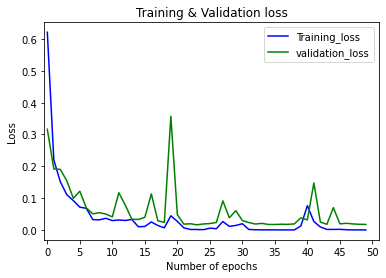

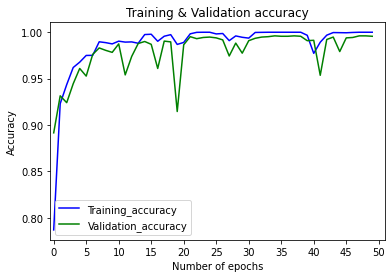

In [ ]:
from matplotlib.pyplot import MultipleLocator
# visualization
plt.plot(range(n_epochs), training_loss_epochs, 'b-', label='Training_loss')
plt.plot(range(n_epochs), validation_loss_epochs, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.xticks(range(n_epochs))

x_major_locator=MultipleLocator(5)#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)#把x轴的主刻度设置为1的倍数
plt.xlim(-0.5,n_epochs+1)#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白

plt.legend()
plt.show()


plt.plot(range(n_epochs), training_accuracy_epochs, 'b-', label='Training_accuracy')
plt.plot(range(n_epochs), validation_accuracy_epochs, 'g-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.xticks(range(n_epochs))

x_major_locator=MultipleLocator(5)#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)#把x轴的主刻度设置为1的倍数
plt.xlim(-0.5,n_epochs+1)#把x轴的刻度范围设置为-0.5到11，因为0.5不满一个刻度间隔，所以数字不会显示出来，但是能看到一点空白

'''
————————————————
版权声明：本文为CSDN博主「宁宁Fingerstyle」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/weixin_44520259/article/details/89917026
'''
plt.legend()
plt.show()

# Test our model

Actual: 2
Prediction: tensor([[ -4.0934,  -7.0413,  12.7168,   1.3848, -11.6832,   2.5989]],
       device='cuda:0', grad_fn=<AddmmBackward>)


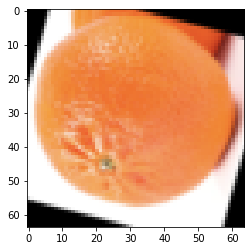

In [16]:
img,label = test_set[1000]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
Categories=['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

In [15]:
# ---------- Test ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

y_test = []
y_test_predict = []

for img,label in test_set:
  out = model(img.unsqueeze(0).to(device))
  predict_value = int(out.argmax(dim=-1))

  # Record the loss and accuracy.
  y_test.append(label)
  y_test_predict.append(predict_value)

print("Test data")

print(f"The model is {accuracy_score(y_test, y_test_predict)*100}% accurate")
print("report:\n",classification_report(y_test, y_test_predict, target_names=Categories, digits=4))
print("confusion matrix:\n",confusion_matrix(y_test, y_test_predict))


Test data
The model is 99.51816160118607% accurate
report:
                precision    recall  f1-score   support

  freshapples     0.9949    0.9975    0.9962       395
  freshbanana     0.9974    0.9974    0.9974       381
 freshoranges     0.9948    0.9871    0.9909       388
 rottenapples     0.9983    0.9933    0.9958       601
 rottenbanana     0.9962    1.0000    0.9981       530
rottenoranges     0.9877    0.9950    0.9913       403

     accuracy                         0.9952      2698
    macro avg     0.9949    0.9951    0.9950      2698
 weighted avg     0.9952    0.9952    0.9952      2698

confusion matrix:
 [[394   1   0   0   0   0]
 [  0 380   0   0   1   0]
 [  0   0 383   0   0   5]
 [  2   0   1 597   1   0]
 [  0   0   0   0 530   0]
 [  0   0   1   1   0 401]]


In [ ]:
diff_idx = []

for i in range(len(y_test)):
  if y_test[i] != y_test_predict[i]:
    diff_idx.append(i)
    # first_diff_idx = i
    # break

In [ ]:
len(diff_idx)

105

Actual: 4
Prediction: tensor([[-20.5922,  -9.2349, -14.4395,  17.3489,  10.2662,  -4.1480]],
       device='cuda:0', grad_fn=<AddmmBackward>)


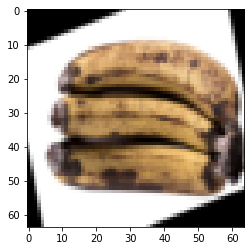

In [ ]:
img,label = test_set[diff_idx[30]]
plt.imshow(img.permute(1,2,0))
out = model(img.unsqueeze(0).to(device))
print('Actual: {}'.format(label))
print('Prediction: {}'.format(out))

In [ ]:
### 再測一次train的準確度，總感覺前面訓練過程中他是先抓資料再更新model
# ---------- Train ----------
# Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
model.eval()

y_train = []
y_train_predict = []

for img,label in train_set:
  out = model(img.unsqueeze(0).to(device))
  predict_value = int(out.argmax(dim=-1))

  # Record the loss and accuracy.
  y_train.append(label)
  y_train_predict.append(predict_value)

print("Train data")

print(f"The model is {accuracy_score(y_train, y_train_predict)*100}% accurate")
print("report:\n",classification_report(y_train, y_train_predict, target_names=Categories, digits=4))
print("confusion matrix:\n",confusion_matrix(y_train, y_train_predict))


Train data
The model is 100.0% accurate
report:
                precision    recall  f1-score   support

  freshapples     1.0000    1.0000    1.0000      1373
  freshbanana     1.0000    1.0000    1.0000      1257
 freshoranges     1.0000    1.0000    1.0000      1159
 rottenapples     1.0000    1.0000    1.0000      1880
 rottenbanana     1.0000    1.0000    1.0000      1778
rottenoranges     1.0000    1.0000    1.0000      1273

     accuracy                         1.0000      8720
    macro avg     1.0000    1.0000    1.0000      8720
 weighted avg     1.0000    1.0000    1.0000      8720

confusion matrix:
 [[1373    0    0    0    0    0]
 [   0 1257    0    0    0    0]
 [   0    0 1159    0    0    0]
 [   0    0    0 1880    0    0]
 [   0    0    0    0 1778    0]
 [   0    0    0    0    0 1273]]


In [ ]:
# for google colab
# REMEMBER to execute this line once you've modified any .py code!
# Save the .py code you have modified to your Google Drive
!cp ./*.py ./gdrive/Shareddrives/'AI Final Project'/code/